#  <center><font color=#01B8AA>Detection of brain tumors based on images</font></center>

The data used in this notebook comes from the public dataset <b>Brain tumor MRI</b> available on Kaggle :
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

## Libraries

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# from skimage.transform import resize
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

   ## A look at the images

Let's load our images, classified with respect to the type of tumor they represent and get some information about them.

In [2]:
train_dir = "./Training"
test_dir = "./Testing"

In [3]:
tumors = ['glioma', 'meningioma', 'notumor', 'pituitary']
list_tumor_train=[]
for tumor in tumors:
    number_of_images = len(os.listdir(os.path.join(train_dir, tumor)))
    list_tumor_train.append(number_of_images)
    print(f'There are {number_of_images} for the {tumor} category.')

There are 1321 for the glioma category.
There are 1339 for the meningioma category.
There are 1595 for the notumor category.
There are 1457 for the pituitary category.


We can also visualize an example of brain for each tumor type.

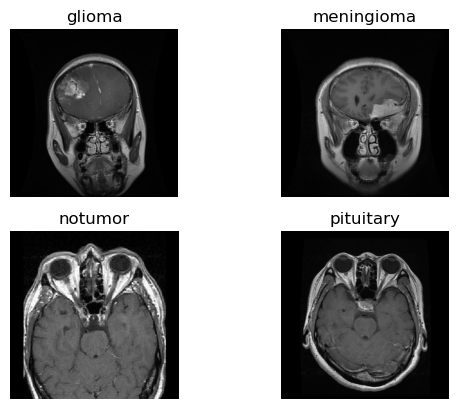

In [4]:
for i, tumor in enumerate(tumors):
    plt.subplot(2, 2,i + 1)
    images_list = os.listdir(os.path.join(train_dir, tumor))
    img=Image.open(os.path.join(train_dir, tumor, images_list[0]))
    plt.axis('off')
    plt.imshow(img)
    plt.title(f'{tumor}')
plt.show()

Let's plot the distribution of the images with respect to their class, for the training dataset

In [5]:
df_train_tum=pd.DataFrame({
    "Type of tumors":tumors,
    "Number":list_tumor_train
})

Text(0.5, 1.0, 'Number of images for each category on the training set')

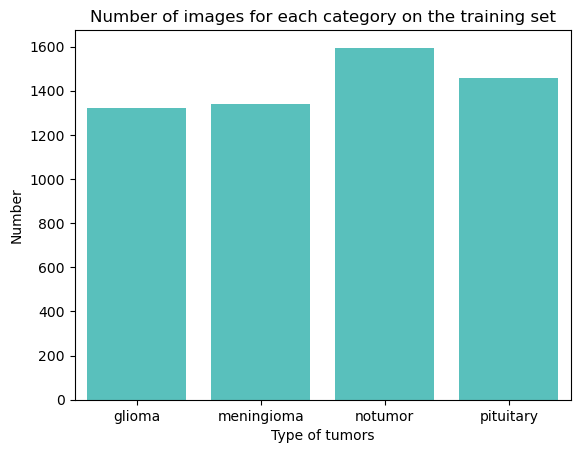

In [6]:
ax = sns.barplot(
    data=df_train_tum,
    x="Type of tumors",
    y="Number",
    color='mediumturquoise'
)
ax.set_title("Number of images for each category on the training set")

Let's now do the same for the test dataset

In [7]:
list_tumor_test=[]
for tumor in tumors:
    number_of_images = len(os.listdir(os.path.join(test_dir, tumor)))
    list_tumor_test.append(number_of_images)
    print(f'There are {number_of_images} for the {tumor} category.')

There are 300 for the glioma category.
There are 306 for the meningioma category.
There are 405 for the notumor category.
There are 300 for the pituitary category.


In [8]:
df_test_tum=pd.DataFrame({
    "Type of tumors":tumors,
    "Number":list_tumor_test
})

Text(0.5, 1.0, 'Number of images for each category on the testing set')

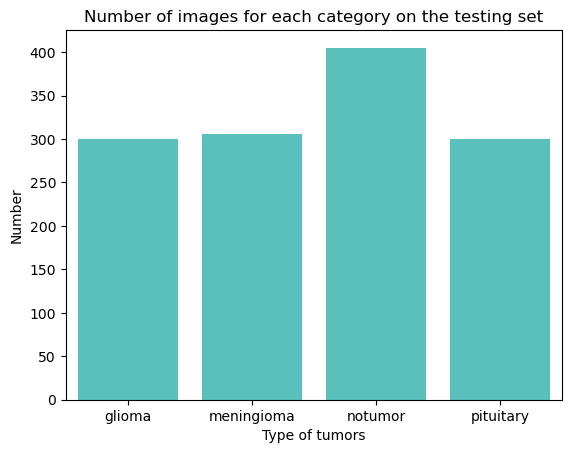

In [9]:
ax = sns.barplot(
    data=df_test_tum,
    x="Type of tumors",
    y="Number",
    color='mediumturquoise'
)
ax.set_title("Number of images for each category on the testing set")

We can see that in both sets, the data is balanced.

## Creating and training CNN

In [10]:
glioma_train = os.path.join(train_dir, 'glioma')
meningioma_train = os.path.join(train_dir, 'meningioma')
notumor_train = os.path.join(train_dir, 'notumor')
pituitary_train = os.path.join(train_dir, 'pituitary')

glioma_test = os.path.join(test_dir, 'glioma')
meningioma_test = os.path.join(test_dir, 'meningioma')
notumor_test = os.path.join(test_dir, 'notumor')
pituitary_test = os.path.join(test_dir, 'pituitary')

In [11]:
num_glioma_train = len(os.listdir(glioma_train))
num_meningioma_train = len(os.listdir(meningioma_train))
num_notumor_train = len(os.listdir(notumor_train))
num_pituitary_train = len(os.listdir(pituitary_train))

num_glioma_test = len(os.listdir(glioma_test))
num_meningioma_test = len(os.listdir(meningioma_test))
num_notumor_test = len(os.listdir(notumor_test))
num_pituitary_test = len(os.listdir(pituitary_test))

print('total train:', num_glioma_train+num_meningioma_train+num_notumor_train+num_pituitary_train)
print('total test:', num_glioma_test+num_meningioma_test+num_notumor_test+num_pituitary_test)

total train: 5712
total test: 1311


Let's define some methods we'll use later to structure the data, and then define and fit the model.

In [41]:
# Function to apply transformation to images 
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1) # Grayscale
    img = tf.image.resize(img, (256,256))
    return img, label


# Function to one-hot encode the labels and therefore to be able later to use CategoricalCrossEntropy
def one_hot_encode_labels(image, label, nbr_classes):
    label = tf.one_hot(label, depth=nbr_classes)
    return image, label

# Data augmentation applied to images before being given to the model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255)
  ,tf.keras.layers.RandomFlip("horizontal_and_vertical")
  ,tf.keras.layers.RandomRotation(0.1,  fill_mode = 'nearest'),
  #,tf.keras.layers.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1, 0.3), fill_value=0.0),
  #,tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_value=0.0)
])

# Creation of the CNN model
nbr_classes = 4
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=4,
                                              min_delta=0.001)

# Applying many convolutional layers without reducing the shape helps getting details in images, like tumors

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(64, (2,2), padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(strides=2, padding='same'),

  tf.keras.layers.Conv2D(64, (2,2), padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(padding='same'),
    
  tf.keras.layers.Conv2D(128, (2,2), 3, padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  #tf.keras.layers.MaxPooling2D(strides=1, padding='same'),
    
  tf.keras.layers.Conv2D(128, (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(strides=1, padding='same'),
    
  tf.keras.layers.Conv2D(128, (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(strides=1, padding='same'),

  tf.keras.layers.Conv2D(256, (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(strides=1, padding='same'),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(128,kernel_regularizer='l2'),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(rate=0.4),
  tf.keras.layers.Dense(nbr_classes, activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])



In [32]:
image_paths = []
classes = []
tumors = ['glioma', 'meningioma', 'notumor', 'pituitary']
for c,tumor in enumerate(tumors):
    for im in os.listdir(os.path.join(train_dir, tumor)) :
        image_paths.append(os.path.join(os.path.join(train_dir, tumor), im))
        classes.append(c)

image_paths = np.array(image_paths)
classes = np.array(classes)

train_images, val_images, train_classes, val_classes = train_test_split(
    image_paths, 
    classes, 
    test_size=0.2,
    shuffle=True, 
    stratify=classes,
    random_state=1
)

train_data_gen = tf.data.Dataset.from_tensor_slices((train_images, train_classes))
valid_data_gen = tf.data.Dataset.from_tensor_slices((val_images, val_classes))

# Performance configuration (next steps optimization)
# We configure the data so that images are kept in cache. The prefetch method enables to get the data before it is asked by the model.
AUTOTUNE = tf.data.AUTOTUNE
train_data_gen = train_data_gen.cache().prefetch(buffer_size=AUTOTUNE)
valid_data_gen = valid_data_gen.cache().prefetch(buffer_size=AUTOTUNE)

# Data processing to rtraining and validation sets
train_data_gen = train_data_gen.map(process_image).batch(64)
valid_data_gen = valid_data_gen.map(process_image).batch(32)
train_data_gen = train_data_gen.map(lambda x, y: one_hot_encode_labels(x, y, nbr_classes))
valid_data_gen = valid_data_gen.map(lambda x, y: one_hot_encode_labels(x, y, nbr_classes))


# Model computing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=4,
                                          min_delta=0.001,
                                          restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_epoch', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min')

model.fit(
  train_data_gen,
  validation_data=valid_data_gen,
  epochs=15,
  callbacks=[checkpoint, early_stopping],
)

dict_val_perf = {}
val_perf = model.evaluate(valid_data_gen)
dict_val_perf['val_loss'] = val_perf[0]
dict_val_perf['val_precision'] = val_perf[1]
dict_val_perf['val_recall'] = val_perf[2]
F1 = lambda prec, acc : 2 * (prec * acc) / (prec + acc) if prec != 0 and acc != 0 else 0
dict_val_perf['val_F1'] = F1(val_perf[1], val_perf[2])

print(dict_val_perf)

Epoch 1/15
72/72 [==============================] - ETA: 0s - loss: 1.5130 - precision_3: 0.7646 - recall_3: 0.5688INFO:tensorflow:Assets written to: best_model_epoch\assets


INFO:tensorflow:Assets written to: best_model_epoch\assets


72/72 [==============================] - 164s 2s/step - loss: 1.5130 - precision_3: 0.7646 - recall_3: 0.5688 - val_loss: 3.0595 - val_precision_3: 0.2310 - val_recall_3: 0.2310
Epoch 2/15
72/72 [==============================] - ETA: 0s - loss: 1.2787 - precision_3: 0.7952 - recall_3: 0.6435INFO:tensorflow:Assets written to: best_model_epoch\assets


INFO:tensorflow:Assets written to: best_model_epoch\assets


72/72 [==============================] - 146s 2s/step - loss: 1.2787 - precision_3: 0.7952 - recall_3: 0.6435 - val_loss: 3.0541 - val_precision_3: 0.2426 - val_recall_3: 0.2371
Epoch 3/15
72/72 [==============================] - 160s 2s/step - loss: 1.1625 - precision_3: 0.8100 - recall_3: 0.6923 - val_loss: 4.1127 - val_precision_3: 0.2375 - val_recall_3: 0.2327
Epoch 4/15
72/72 [==============================] - ETA: 0s - loss: 1.0197 - precision_3: 0.8314 - recall_3: 0.7352INFO:tensorflow:Assets written to: best_model_epoch\assets


INFO:tensorflow:Assets written to: best_model_epoch\assets


72/72 [==============================] - 166s 2s/step - loss: 1.0197 - precision_3: 0.8314 - recall_3: 0.7352 - val_loss: 3.0124 - val_precision_3: 0.2963 - val_recall_3: 0.2660
Epoch 5/15
72/72 [==============================] - ETA: 0s - loss: 0.9135 - precision_3: 0.8573 - recall_3: 0.7796INFO:tensorflow:Assets written to: best_model_epoch\assets


INFO:tensorflow:Assets written to: best_model_epoch\assets


72/72 [==============================] - 177s 2s/step - loss: 0.9135 - precision_3: 0.8573 - recall_3: 0.7796 - val_loss: 1.7412 - val_precision_3: 0.6246 - val_recall_3: 0.1864
Epoch 6/15
72/72 [==============================] - 173s 2s/step - loss: 0.8707 - precision_3: 0.8689 - recall_3: 0.7978 - val_loss: 4.4512 - val_precision_3: 0.3893 - val_recall_3: 0.3771
Epoch 7/15
72/72 [==============================] - ETA: 0s - loss: 0.8719 - precision_3: 0.8627 - recall_3: 0.7905INFO:tensorflow:Assets written to: best_model_epoch\assets


INFO:tensorflow:Assets written to: best_model_epoch\assets


72/72 [==============================] - 176s 2s/step - loss: 0.8719 - precision_3: 0.8627 - recall_3: 0.7905 - val_loss: 1.5097 - val_precision_3: 0.6816 - val_recall_3: 0.5976
Epoch 8/15
72/72 [==============================] - 172s 2s/step - loss: 0.8076 - precision_3: 0.8659 - recall_3: 0.7969 - val_loss: 3.5560 - val_precision_3: 0.4778 - val_recall_3: 0.4707
Epoch 9/15
72/72 [==============================] - ETA: 0s - loss: 0.7606 - precision_3: 0.8874 - recall_3: 0.8140INFO:tensorflow:Assets written to: best_model_epoch\assets


INFO:tensorflow:Assets written to: best_model_epoch\assets


72/72 [==============================] - 174s 2s/step - loss: 0.7606 - precision_3: 0.8874 - recall_3: 0.8140 - val_loss: 1.4646 - val_precision_3: 0.7366 - val_recall_3: 0.6754
Epoch 10/15
72/72 [==============================] - ETA: 0s - loss: 0.7085 - precision_3: 0.8817 - recall_3: 0.8402INFO:tensorflow:Assets written to: best_model_epoch\assets


INFO:tensorflow:Assets written to: best_model_epoch\assets


72/72 [==============================] - 188s 3s/step - loss: 0.7085 - precision_3: 0.8817 - recall_3: 0.8402 - val_loss: 1.1506 - val_precision_3: 0.8042 - val_recall_3: 0.7795
Epoch 11/15
72/72 [==============================] - 191s 3s/step - loss: 0.6600 - precision_3: 0.8923 - recall_3: 0.8520 - val_loss: 3.1765 - val_precision_3: 0.5787 - val_recall_3: 0.5372
Epoch 12/15
72/72 [==============================] - 193s 3s/step - loss: 0.6253 - precision_3: 0.8970 - recall_3: 0.8597 - val_loss: 3.4273 - val_precision_3: 0.5381 - val_recall_3: 0.5188
Epoch 13/15
72/72 [==============================] - 190s 3s/step - loss: 0.6004 - precision_3: 0.9043 - recall_3: 0.8643 - val_loss: 1.2139 - val_precision_3: 0.7651 - val_recall_3: 0.6868
Epoch 14/15
36/36 [==============================] - 9s 257ms/step - loss: 1.1506 - precision_3: 0.8042 - recall_3: 0.7795
{'val_loss': 1.1506212949752808, 'val_precision': 0.8041516542434692, 'val_recall': 0.7795275449752808, 'val_F1': 0.7916481635036

## CNN applied to the Testing Set

In [33]:
# Lets' first apply the same transformation to the test set as to the training set

image_paths = []
classes = []
tumors = ['glioma', 'meningioma', 'notumor', 'pituitary']
for c,tumor in enumerate(tumors):
    for im in os.listdir(os.path.join(test_dir, tumor)) :
        image_paths.append(os.path.join(os.path.join(test_dir, tumor), im))
        classes.append(c)

image_paths = np.array(image_paths)
classes = np.array(classes)

test_data_gen = tf.data.Dataset.from_tensor_slices((image_paths, classes))
test_data_gen = test_data_gen.map(process_image).batch(1)
test_data_gen = test_data_gen.map(lambda x, y: one_hot_encode_labels(x, y, nbr_classes))

In [39]:
# We get the predictions
best_model_epoch = tf.keras.models.load_model('best_model_epoch')
im_pred = best_model_epoch.predict(test_data_gen)
im_pred_class = np.argmax(im_pred, axis=1)

1311/1311 [==============================] - 27s 21ms/step


In [40]:
# We can now compare the predictions to the true classes

im_true_class = np.argmax(np.concatenate([y for x, y in test_data_gen], axis=0), axis=1)

tot_test = 0
tot_correct = 0
for i, class_name in enumerate(tumors):
     im_pred_class_i = im_pred_class == np.full(im_pred_class.shape, i)
     im_true_class_i = im_true_class == np.full(im_true_class.shape, i)
     im_common_class_i = im_pred_class_i == im_true_class_i 
     im_max_class_i = np.maximum(im_pred_class_i, im_true_class_i)
     im_correct_class_i = im_common_class_i == im_max_class_i
     correct = im_correct_class_i.sum()
     tot_correct += correct
     number = len(os.listdir(os.path.join(test_dir, class_name)))
     tot_test += number
     print(f"{class_name} class correctly classified : {correct} for {number} images.")
proportion = round(tot_correct * 100 / tot_test,2)
print(f"Proportion of images correctly classified : {proportion}%.")


glioma class correctly classified : 155 for 300 images.
meningioma class correctly classified : 122 for 306 images.
notumor class correctly classified : 350 for 405 images.
pituitary class correctly classified : 290 for 300 images.
Proportion of images correctly classified : 69.95%.


## Results

We finally have almost 70% of the images correctly classified. If we take a look at the final results, we can see that the model can quite correctly detect if there's a tumor, but it is less performing to detect what kind of tumor is present. 

With a more powerful device, we might be able to add filters, convolutional layers without reducing to much the size so that the model distinguishes better the complex differences between tumors.